In [92]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import haversine_distances

In order to avoid crashing the kernel, only read a portion of the data

In [93]:
df = pd.read_csv('train.csv', nrows = 1_000_000)
df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In order to determine the amount of distance traveled, use the Haversine formula

Note, I didn't use Euclidean distance because the coordinates are points on a sphere. 

In [94]:
def hav_distance(lon1, lat1, lon2, lat2):
    # use sklearn's haversine function and multiply by Earth's radius to get distance in km
    return haversine_distances([[lon1, lat1], [lon2, lat2]])[0][1] * 6371000/1000

# create new feature using this function, distance in km
df['distance_traveled_km'] = df.apply(lambda x: hav_distance(x['pickup_longitude'], x['pickup_latitude'], 
                                                             x['dropoff_longitude'], x['dropoff_latitude']), axis=1)

To clean the data, drop any NaNs from the df

In [95]:
df = df.dropna(axis='rows')
print('New number of observations: %d' % len(df))

New number of observations: 999990


Find distribution of the distance traveled

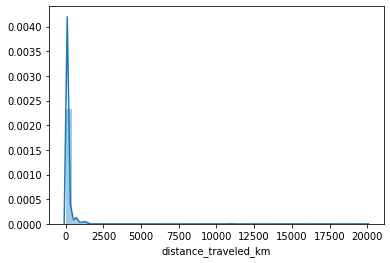

In [96]:
sns.distplot(df['distance_traveled_km'])

In [97]:
df['distance_traveled_km'].quantile(.95)

621.2290233476851

Some of the observations are too high to make sense, so take out all of the rows where the distance traveled is above the 95th percentile, then also take out all of the rows where the distances is 0

In [98]:
df = df[df['distance_traveled_km'] <= df['distance_traveled_km'].quantile(.95)]
df = df[df['distance_traveled_km'] > 0]
df['distance_traveled_km'].describe()

count    921504.000000
mean        107.724525
std          96.291255
min           0.000214
25%          42.439587
50%          80.011456
75%         141.368595
max         621.220036
Name: distance_traveled_km, dtype: float64

New distribution after the filtering

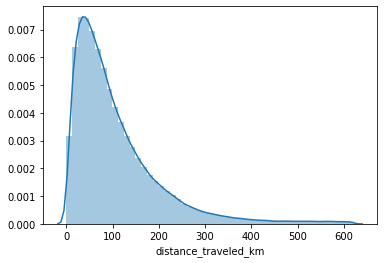

In [99]:
sns.distplot(df['distance_traveled_km'])

Some of the fares also make no sense, so fix that too.

Since as of 2018, the lowest base fee for a taxi ride in NYC is $2.50, I'll drop observations with fare_amount below 1.5

In [100]:
df = df[df['fare_amount'] > 1.5]

In [103]:
df['fare_amount'].quantile(.999)

57.33

If the 99.9th percentile is less than 52, it looks safe to just cut out values >= 60

In [104]:
df = df[df['fare_amount'] < 60]
df['fare_amount'].describe()

count    920744.000000
mean          9.757954
std           5.886955
min           2.500000
25%           6.000000
50%           8.100000
75%          11.700000
max          59.830000
Name: fare_amount, dtype: float64

Text(0.5, 1.0, 'Histogram')

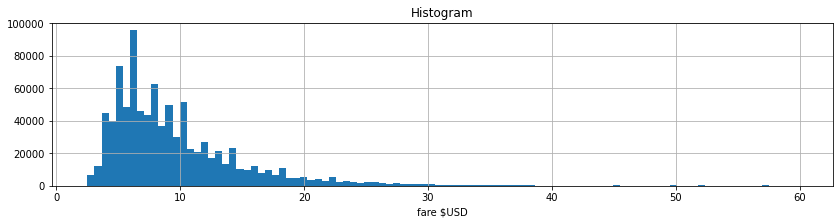

In [105]:
df.fare_amount.hist(bins=100, figsize=(14,3))
plt.xlabel('fare $USD')
plt.title('Histogram')

Then cut out all of the rows where the passenger count is zero

In [108]:
df = df[df['passenger_count'] > 0]

Basically what I'm thinking at this point is to first figure out what other values don't make sense and take them out of the data. Then I want to convert the pickup_datetime into a useable timestamp. Finally, I think it could be helpful to build a multiple linear regression using the distance_traveled, passenger_count, and time of day based on the time stamp

In [28]:
df['distance_traveled_km'].describe()

count    921456.000000
mean        107.728141
std          96.290639
min           0.000214
25%          42.443099
50%          80.014014
75%         141.372361
max         621.220036
Name: distance_traveled_km, dtype: float64